## Preambule

In [1]:
# General packages
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import xarray as xr
import json

# Plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.colors import n_colors

## Paths

In [2]:
path_data = Path("K:/Data/Data_effortsharing/DataUpdate_ongoing")
path_figs = Path("K:/Code/effort-sharing/") / "Figures" / "Paper_Robiou2023"

## Read data files

In [3]:
xr_dataread = xr.open_dataset(path_data / 'startyear_2021' / "xr_dataread.nc")
xr_comb_2015 = xr.open_dataset(path_data / 'startyear_2015' / "xr_comb_GHG_excl.nc")
xr_comb_2021 = xr.open_dataset(path_data / 'startyear_2021' / "xr_comb_GHG_excl.nc")
xr_temp_2015 = xr.open_dataset(path_data / 'startyear_2015' / "xr_combtemps_GHG_excl.nc")
xr_temp_2021 = xr.open_dataset(path_data / 'startyear_2021' / "xr_combtemps_GHG_excl.nc")
all_regions_iso = np.load(path_data / "all_regions.npy")
all_regions_names = np.array(list(np.load(path_data / "all_regions_names.npy")[:-1])+['Earth']) # Only in old xr_dataread version, should be updated when reran
all_countries_iso = np.load(path_data / "all_countries.npy", allow_pickle=True)
all_countries_names = np.load(path_data / "all_countries_names.npy", allow_pickle=True)
only_regions_iso = ['CVF', 'G20', "EU", "G7", "NA", "AU", "AF", "SIDS", "LDC", "WORLD"]
only_regions_names = ['Climate Vulnerability Forum','G20',"European Union","G7","Northern America","Australasia","African Group","Small Island Developing States","Least Developed Countries", 'World']

In [4]:
df_g = pd.read_excel(Path("X:/user/dekkerm/Data/") / "UNFCCC_Parties_Groups_noeu.xlsx", sheet_name = "Country groups")
countries_iso = np.array(df_g["Country ISO Code"])
countries_name = np.array(df_g["Name"])
countries_iso = np.array(df_g["Country ISO Code"])
group_cvf = countries_iso[np.array(df_g["CVF (24/10/22)"]) == 1]
group_g20 = countries_iso[np.array(df_g["G20"]) == 1]
group_eu = countries_iso[np.array(df_g["EU"]) == 1]
group_g7 = countries_iso[np.array(df_g["G7"]) == 1]
group_na = countries_iso[np.array(df_g["Northern America"]) == 1]
group_um = countries_iso[np.array(df_g["Umbrella"]) == 1]
group_au = countries_iso[np.array(df_g["Australasia"]) == 1]
group_af = countries_iso[np.array(df_g["African Group"]) == 1]
group_sids = countries_iso[np.array(df_g["SIDS"]) == 1]
group_ldc = countries_iso[np.array(df_g["LDC"]) == 1]
group_eg = countries_iso[np.array(df_g["European Group"]) == 1]
group_world = np.copy(countries_iso)

In [5]:
settings_ndc = {"Conditionality": 'unconditional',
                "Hot_air": 'include'}

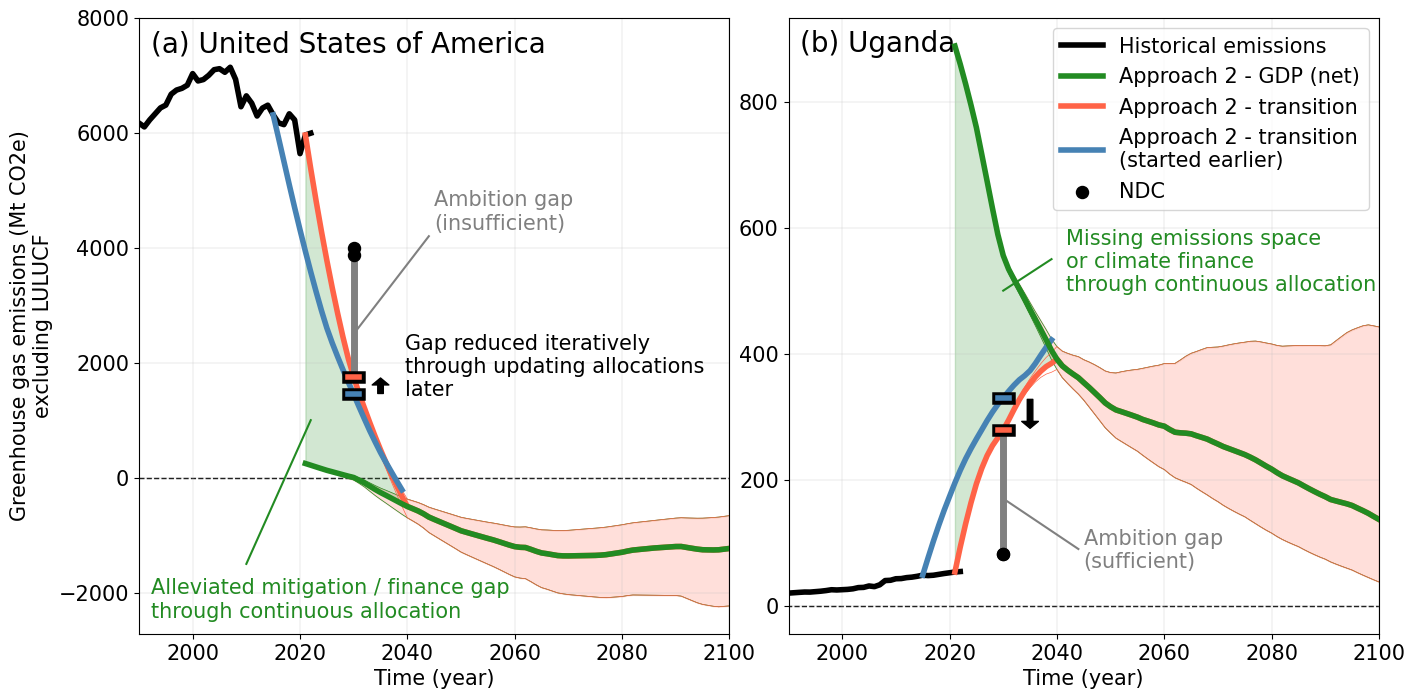

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=False)

xr_combs_sel = xr_comb_2021.sel(Temperature=1.6, Risk=0.5, Convergence_year=2040)
xr_combs_sel15 = xr_comb_2015.sel(Temperature=1.6, Risk=0.5, Convergence_year=2040)

for reg_i, reg in enumerate(['USA', 'UGA']):
    ax = [ax1, ax2][reg_i]
    ax.set_xlim([1990, 2100])
    ax.grid(color='silver', linestyle='-', linewidth=0.25)
    
    ax.plot(xr_dataread.Time, xr_dataread.GHG_hist_excl.sel(Region=reg), label='Historical emissions', c='black', lw=4)
    
    ax.plot(xr_comb_2021.Time, xr_combs_sel.Approach2.sel(Region=reg).max(dim=['Discount_factor', 'Historical_startyear', 'Scenario']), c='forestgreen', lw=0.5)
    ax.plot(xr_comb_2021.Time, xr_combs_sel.Approach2.sel(Region=reg).median(dim=['Discount_factor', 'Historical_startyear', 'Scenario']), label='Approach 2 - GDP (net)', c='forestgreen', lw=4, zorder=1e9)
    ax.plot(xr_comb_2021.Time, xr_combs_sel.Approach2.sel(Region=reg).min(dim=['Discount_factor', 'Historical_startyear', 'Scenario']), c='forestgreen', lw=0.5)

    # shade area between min and max
    ax.fill_between(xr_comb_2021.Time, xr_combs_sel.Approach2.sel(Region=reg).min(dim=['Discount_factor', 'Historical_startyear', 'Scenario']), xr_combs_sel.Approach2.sel(Region=reg).max(dim=['Discount_factor', 'Historical_startyear', 'Scenario']), color='tomato', alpha=0.2)

    ax.plot(xr_comb_2021.Time, xr_combs_sel.Approach2t.sel(Region=reg).max(dim=['Discount_factor', 'Historical_startyear', 'Scenario']), c='tomato', lw=0.5)
    ax.plot(xr_comb_2021.Time, xr_combs_sel.Approach2t.sel(Region=reg).median(dim=['Discount_factor', 'Historical_startyear', 'Scenario']), label='Approach 2 - transition', c='tomato', lw=4)
    ax.plot(xr_comb_2021.Time, xr_combs_sel.Approach2t.sel(Region=reg).min(dim=['Discount_factor', 'Historical_startyear', 'Scenario']), c='tomato', lw=0.5)

    # Hypothetical earlier start
    ax.plot(xr_comb_2015.Time.sel(Time=np.arange(2015, 2040)),
            xr_combs_sel15.Approach2t.sel(Region=reg).sel(Time=np.arange(2015, 2040)).median(dim=['Discount_factor', 'Historical_startyear', 'Scenario']),
            #'',
            label='Approach 2 - transition\n(started earlier)', c='steelblue', lw=4)

    # shade area between approach2 and approach2t
    ax.fill_between(xr_comb_2021.Time, xr_combs_sel.Approach2.sel(Region=reg).median(dim=['Discount_factor', 'Historical_startyear', 'Scenario']), xr_combs_sel.Approach2t.sel(Region=reg).median(dim=['Discount_factor', 'Historical_startyear', 'Scenario']), color='forestgreen', alpha=0.2)

    ax.plot([-1e3, 1e5], [0, 0], 'k--', lw=1, zorder=-1e9)

    ax.scatter([2030, 2030], [xr_dataread.GHG_ndc_excl_CR.sel(Region=reg, **settings_ndc).min(dim='Ambition'),
                              xr_dataread.GHG_ndc_excl_CR.sel(Region=reg, **settings_ndc).max(dim='Ambition')], c='black', s=75, zorder=1e9, label='NDC')
    ax.plot([2030, 2030], [xr_dataread.GHG_ndc_excl_CR.sel(Region=reg, **settings_ndc).min(dim='Ambition'),
                           xr_dataread.GHG_ndc_excl_CR.sel(Region=reg, **settings_ndc).max(dim='Ambition')], c='black', lw=3, zorder=1e9)

    # Set annotation in top-left corner
    ax.text(0.02, 0.98, ['(a) United States of America', '(b) Uganda'][reg_i], transform=ax.transAxes, fontsize=20, verticalalignment='top')#, bbox=dict(facecolor='white', alpha=0.5))
    ax.set_xlabel('Time (year)', fontsize=15)
    ax.plot([2030, 2030], [xr_combs_sel.Approach2t.sel(Region=reg, Time=2030).median(dim=['Discount_factor', 'Historical_startyear', 'Scenario']),
                           xr_dataread.GHG_ndc_excl_CR.sel(Region=reg, **settings_ndc).min(dim='Ambition')], lw=5, c='grey')
    
    val = xr_combs_sel.Approach2t.sel(Region=reg, Time=2030).median(dim=['Discount_factor', 'Historical_startyear', 'Scenario'])
    ax.plot([2029, 2031], [val, val], c='tomato', lw=4, zorder=1e9)
    ax.plot([2029, 2031], [val, val], c='black', lw=9, zorder=1e9-1)

    val2 = xr_combs_sel15.Approach2t.sel(Region=reg, Time=2030).median(dim=['Discount_factor', 'Historical_startyear', 'Scenario'])
    ax.plot([2029, 2031], [val2, val2], c='steelblue', lw=4, zorder=1e9)
    ax.plot([2029, 2031], [val2, val2], c='black', lw=9, zorder=1e9-1)
    
    ax.annotate('', xy=(2035, val), xytext=(2035, val2),
                arrowprops=dict(facecolor='black', shrink=0.05, headlength=5, headwidth=12))


    ax.text(0.5, [0.65, 0.1][reg_i], 'Ambition gap\n'+['(insufficient)', '(sufficient)'][reg_i], transform=ax.transAxes, fontsize=15, color='grey', verticalalignment='bottom')
    
ax1.set_ylim([ax1.get_ylim()[0], 8000])
ax1.set_ylabel('Greenhouse gas emissions (Mt CO2e)\nexcluding LULUCF', fontsize=15)

# Set horizontal spacing between subplots
plt.subplots_adjust(wspace=0.10)

# Annotation mid-left of first panel
ax1.text(0.02, 0.02, 'Alleviated mitigation / finance gap\nthrough continuous allocation', transform=ax1.transAxes, fontsize=15, color='forestgreen', verticalalignment='bottom')
ax1.text(0.45, 0.38, 'Gap reduced iteratively\nthrough updating allocations\nlater', transform=ax1.transAxes, fontsize=15, color='black', verticalalignment='bottom')
ax2.text(0.47, 0.55, 'Missing emissions space\nor climate finance\nthrough continuous allocation', transform=ax2.transAxes, fontsize=15, color='forestgreen', verticalalignment='bottom')

# Lines
ax1.plot([2010, 2022], [-1500, 1000], c='forestgreen')
ax2.plot([2030, 2039], [500, 550], c='forestgreen')
ax1.plot([2030, 2044], [2500, 4200], c='grey')
ax2.plot([2030, 2044], [170, 90], c='grey')
#ax2.plot([2030, 2044], [3800, 4400], c='steelblue')

# Set y and x tick fontsizes
plt.setp(ax1.get_yticklabels(), fontsize=15)
plt.setp(ax1.get_xticklabels(), fontsize=15)
plt.setp(ax2.get_xticklabels(), fontsize=15)
plt.setp(ax2.get_yticklabels(), fontsize=15)

plt.legend(loc = 'upper right', fontsize=15)

plt.savefig(path_figs / "Figure_1.png", dpi=300)